In [1]:
import xarray as xr
import xarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import glob
import scipy
val = 0


In [1]:

def len_iter(items):
    return sum(1 for _ in items)

def consecutive_one(data):
    return max(len_iter(run) for val, run in groupby(data) if val)

def test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid):
    """
    test centroid position
    """
    if len([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid]) == 1:
        centroid_pos = ([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid][0])
        var_bool_blocked_idx[cluster[centroid_pos][0], cluster[centroid_pos][1]] = 2
        return True
    else:
        return False

def identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx):
    """
    Identify the location(s) of the centroid within the cluster
    function contains exception handling for if the centroid position (identified using the median lat/lon values)
    is not in the list
    Note that this has been written for a grid resolution of 2x2 - other grid resolutions e.g. 2.5x2.5 might have errors
    """
    try:
        centroid_pos = ([i for i, v in enumerate(cluster) if v[0] == lat_centroid and v[1] == lon_centroid][0])
        var_bool_blocked_idx[cluster[centroid_pos][0], cluster[centroid_pos][1]] = 2
    except IndexError: #when the centroid_pos is not within the cluster (the median lat/lon value isn't part of the cluster)
        #need to adjust lat_centroid and lon_centroid until the closest centre within the cluster is identified
        centroid_not_found = True
        while centroid_not_found:
            for i in range(1,len(lat)):
                #loop through all possible centroid locations starting out from the median location
                #so that if there are two possible locations of the centroid within the cluster both are chosen
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid, lon_centroid-i)
                if centroid_pos_found:
                    centroid_not_found = False #break loop here when the nearest neighbours have been checked
                #if still not found, look at the edge tiles
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid-i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid-i, lon_centroid+i) 
                centroid_pos_found = test_centroid_pos(cluster, var_bool_blocked_idx, lat_centroid+i, lon_centroid-i)
                if centroid_pos_found: #break loop here when the edge tiles have been checked before looping back through
                    centroid_not_found = False

def get_adjacent_indices(i, j, m, n):
    """
    Obtain the adjacent indices where they can be found
    uses the nearest neighbour
    from https://stackoverflow.com/questions/51657128/how-to-access-the-adjacent-cells-of-each-elements-of-matrix-in-python/51657232
    """
    adjacent_indices = []
    if i > 0:
        adjacent_indices.append((i-1,j))
    if i+1 < m:
        adjacent_indices.append((i+1,j))
    if j > 0:
        adjacent_indices.append((i,j-1))
    if j+1 < n:
        adjacent_indices.append((i,j+1))
    return adjacent_indices

def add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals, lat_lon_idx_vals, len_lat, len_lon):
    """
    If not already in the cluster, add adjacent values to the cluster
    """
    if ((lat_idx, lon_idx)) not in cluster:
        #print(f"{(lat_idx, lon_idx)} added to cluster")
        cluster.append((lat_idx, lon_idx))
    adjacent_indices = get_adjacent_indices(lat_idx, lon_idx, len_lat, len_lon)
    #print(f"adjacent_indices = {adjacent_indices}")
    for adj_idx in adjacent_indices:
        if adj_idx in lat_lon_idx_vals:
            if adj_idx not in cluster:
                #add the value and the adjacent values to the cluster
                cluster.append(adj_idx)  
                if adj_idx not in idx_vals:
                    idx_vals.append(adj_idx) # these are the new index values that are going to be iterated over again
    return idx_vals
            
def calc_clusters(var_bool, len_lat, len_lon):
    """
    Returns a list of grouped clusters using the nearest neighbour
    """
    lat_idx_vals, lon_idx_vals = np.where(var_bool > 0)
    lat_lon_idx_vals = [(lat_idx, lon_idx) for lat_idx, lon_idx in zip(lat_idx_vals, lon_idx_vals)]
    cluster, cluster_arr = [], []
    for i in range(lon_idx_vals.shape[0]):
        #need to find in the whole array if there are any matching index values that are adjacent and haven't already been put into the cluster
        lat_idx, lon_idx = lat_lon_idx_vals[i]
        if sum([(lat_idx, lon_idx) in cluster for cluster in cluster_arr]) == 0: #check if lat or lon index already in a cluster
            cluster, idx_vals = [], []
            idx_vals = add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals, lat_lon_idx_vals, len_lat, len_lon)
            num_idx_vals = len(idx_vals) # number of idx vals in cluster not looped across yet
            idx_vals_old, idx_vals_new = idx_vals.copy(), idx_vals.copy()
            while (num_idx_vals > 0): # while there are still index values in the nearest neighbour
                #loop through all the adjacent values that are also blocked
                for lat_idx, lon_idx in (idx_vals_old):
                    #for each adjacent value that is also blocked, identify the new index values
                    idx_vals_new = add_adjacent_idx_to_cluster(lat_idx, lon_idx, cluster, idx_vals_new, lat_lon_idx_vals, len_lat, len_lon)
                    #remove the idx_val that has been looped over from the list
                    idx_vals_new.remove((lat_idx, lon_idx))                
                idx_vals_old = idx_vals_new.copy()
                num_idx_vals = len(idx_vals_old)
            cluster_arr.append((cluster))
        else:
            pass #here if current index in loop is already in a cluster
    return cluster_arr    
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx+1

In [2]:
def area_test(var_bool_samp, lat, lon, area_thresh, area_cell, time_val, i):
    """
    Calculate the polygon shapes, determine the area for the blocked polygons and if there is a
    blocked polygon identify whether or not it passes the area_thresh threshold
    if so, then day is blocked
    #Length of 1 degree of Longitude = cosine (latitude in decimal degrees) * length of degree (miles) at equator
    #Each degree of latitude is approximately 69 miles (111 kilometers) apart
    #The range varies (due to the earth's slightly ellipsoid shape) from 68.703 miles (110.567 km) at the equator to 69.407 (111.699 km) at the poles    
    """
    blocked_day = 0
    
    #plt.pcolormesh(lon,lat,var_bool_samp)
    #CS = plt.contour(lon,lat,var_bool)# corner_mask=True,interpolation='none')
    #print(f"var_bool.sum() = {var_bool.sum()}")
    #plt.close()
    #plt.pcolormesh(lon,lat,var_bool)
    #fig=plt.figure()
    #plt.pcolormesh(lon,lat,var_bool)
    var_bool_blocked_idx = np.zeros((len(lat),len(lon)))#use to identify blocked regions
    cluster_num = 0

    var_bool_blocked_idx=xarray.DataArray(var_bool_samp*0, name = "TM90_clusters", coords=var_bool_samp.coords)
    #print(f"var_bool_blocked_idx = {var_bool_blocked_idx}")
    #calculate all of the clusters for this time step
    cluster_arr = calc_clusters(var_bool_samp, len(lat), len(lon))
    #print(f"var_bool_samp.sum() = {var_bool_samp.sum()}")
    for cluster in cluster_arr:
        #calculate the area of different clusters by projecting the lat/lon values onto a boolean lat/lon grid area_cell grid
        #and multiplying this by the area_cell grid to obtain the area
        var_bool_cluster = np.zeros((len(lat),len(lon)))
        for lat_idx, lon_idx in cluster:
            #print(f"lat_idx, lon_idx = {lat_idx, lon_idx}")
            
            var_bool_cluster[lat_idx,lon_idx] = 1
        #fig = plt.figure()
        #plt.pcolormesh(lon,lat,var_bool_cluster)            
        #print(f"var_bool_cluster = {var_bool_cluster}")    
        area_cell_sum=(area_cell*var_bool_cluster).sum().values
        #plt.pcolormesh(lon,lat,area_cell) 
        #plt.colorbar()
        #print(f"var_bool_cluster.sum() = {var_bool_cluster.sum()}")
        #print(f"area_cell_sum = {area_cell_sum} km^2")
        #print(f"area_cell_sum_tot = {area_cell.sum().values} km^2")
        
        #if this area > area_thresh, add the cluster to the 2D lat/lon grid for overlap calculation
        if area_cell_sum > area_thresh:
            #label day as blocked
            cluster_num += 1
            blocked_day = 1
            for lat_idxs, lon_idxs in cluster:
                var_bool_blocked_idx[lat_idxs,lon_idxs]=1
            #label the centre lat, lon idx value with a 2
            lats_arr, lons_arr = ([i[0] for i in cluster], [i[1] for i in cluster])
            lat_centroid, lon_centroid = (np.median(lats_arr), np.median(lons_arr))
            # if there isn't a value in the middle then set the two neighbouring middle indices to 2 (effectively blur the two centroids)
            #otherwise there would be a bias to highlighting blicking in E/W or N/S directions
            if lon_centroid%1 == 0 and lat_centroid%1 == 0:  
                #print(lat_centroid, lon_centroid)
                #print(cluster)
                identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx)
            else: # if there isn't a value in the middle then set the two neighbouring middle indices to 2 (effectively blur the two centroids)
                if lat_centroid%1 != 0:
                    lat_centroid_arr = [lat_centroid-0.5, lat_centroid+0.5]
                    lon_centroid_arr = [lon_centroid, lon_centroid]
                if lon_centroid%1 != 0:
                    lat_centroid_arr = [lat_centroid, lat_centroid]
                    lon_centroid_arr = [lon_centroid-0.5, lon_centroid+0.5]
                if lon_centroid%1 != 0 and lat_centroid%1 != 0:    #when no middle lat or lon - create a centroid blob containing 4 tiles
                    lon_centroid_arr = [lon_centroid-0.5, lon_centroid+0.5, lon_centroid-0.5, lon_centroid+0.5]
                    lat_centroid_arr = [lat_centroid-0.5, lat_centroid+0.5, lat_centroid+0.5, lat_centroid-0.5]
                for lat_centroid, lon_centroid in zip(lat_centroid_arr, lon_centroid_arr):
                    identify_centroid_within_cluster(lat_centroid, lon_centroid, cluster, var_bool_blocked_idx)
    return var_bool_blocked_idx, cluster_num

In [4]:
def save_block_TM90_2D(zg_file, model, ens, sim, season, Delta, min_blocked_tiles,
                    persis_thresh, overlap_val, styr, endyr, lat_bnds, lon_bnds, grid_res, domain, mip):
    """
    Saves the 2D TM90 fiile for a given blocked region
    """

    print(model, ens)
    #in cmip5 the lat/lon variables are "lat" and "lon", whereas in era5 they are "latitude" and "longitude"
    lat_str="lat"
    lon_str="lon"     
    if model == "era5":
        lat_str="latitude"
        lon_str="longitude"

    E_min = 0 #m per degree latitude
    W_min = -10

    #select European domain with shifts of latitude so that the domains can be subtracted from each other
    #amount the indices need to be shifted by - in Scherrer et al 2005 they used del_lat ir 15 degrees
    #becuase I've regridded to a 2x2 grid shift use 14 degrees
    deg_shift = 14

    #select the time periods for each model from the start and end years
    dayofyr_xr=[zg_file.sel(time=(slice(f"{yr}-05-27", f"{yr}-09-04")))['time'] for yr in range(int(styr),int(endyr)+1)]    
    #select DJF to test TM90 index behaviour
    #dayofyr_xr=[zg_file.sel(time=np.isin(zg_file['time.season'], "DJF"))]       

    #concatenate the lists of boolean DataArray objects - also takes a few seconds
    dayofyr_xr_concat = xarray.concat(dayofyr_xr, "time")
    if lat_str == "latitude":
        Europe_zg_xr = zg_file.sel(longitude = range(lon_bnds[0],lon_bnds[1]+grid_res,grid_res), latitude = range(lat_bnds[0],lat_bnds[1]+grid_res,grid_res),
                                   time = dayofyr_xr_concat['time']).squeeze()

        Europe_zg_xr_S_shift = zg_file.sel(longitude = range(lon_bnds[0],lon_bnds[1]+grid_res,grid_res), latitude = np.arange(lat_bnds[0]-deg_shift,lat_bnds[1]-deg_shift+grid_res,grid_res), 
                                   time = dayofyr_xr_concat['time']).squeeze()

        Europe_zg_xr_N_shift = zg_file.sel(longitude = range(lon_bnds[0],lon_bnds[1]+grid_res,grid_res), latitude = np.arange(lat_bnds[0]+deg_shift,lat_bnds[1]+deg_shift+grid_res,grid_res), 
                                   time = dayofyr_xr_concat['time']).squeeze()
        
    if lat_str == "lat":
        Europe_zg_xr = zg_file.sel(lon = range(lon_bnds[0],lon_bnds[1]+grid_res,grid_res), lat = range(lat_bnds[0],lat_bnds[1]+grid_res,grid_res),
                                   ).squeeze()

        Europe_zg_xr_S_shift = zg_file.sel(lon = range(lon_bnds[0],lon_bnds[1]+grid_res,grid_res), lat = np.arange(lat_bnds[0]-deg_shift,lat_bnds[1]-deg_shift+grid_res,grid_res), 
                                   ).squeeze()

        Europe_zg_xr_N_shift = zg_file.sel(lon = range(lon_bnds[0],lon_bnds[1]+grid_res,grid_res), lat = np.arange(lat_bnds[0]+deg_shift,lat_bnds[1]+deg_shift+grid_res,grid_res), 
                                   ).squeeze()        
        #time = dayofyr_xr_concat['time']
    print(f"Europe_zg_xr = {Europe_zg_xr}")
    #readjust the coordinates so that the subtraction occurs across the same dimensions
    Europe_zg_xr_S_shift[lat_str] = Europe_zg_xr_S_shift[lat_str]+deg_shift
    Europe_zg_xr_N_shift[lat_str] = Europe_zg_xr_N_shift[lat_str]-deg_shift
    
    GHGS=(Europe_zg_xr-Europe_zg_xr_S_shift)/deg_shift
    GHGN=(Europe_zg_xr_N_shift-Europe_zg_xr)/deg_shift
    Europe_zg_xr['GHGN']=xarray.DataArray(data=GHGN, coords=(Europe_zg_xr['time'],Europe_zg_xr[lat_str],Europe_zg_xr[lon_str]))
    Europe_zg_xr['GHGS']=xarray.DataArray(data=GHGS, coords=(Europe_zg_xr['time'],Europe_zg_xr[lat_str],Europe_zg_xr[lon_str])) 
    Europe_zg_xr['blocking_index'] = ((Europe_zg_xr['GHGS'] > E_min ) & (Europe_zg_xr['GHGN'] < W_min))

    TM90_2D_xr = xarray.DataArray(Europe_zg_xr['blocking_index'].values, name = "AGP", coords = (Europe_zg_xr['time'],Europe_zg_xr[lat_str],Europe_zg_xr[lon_str]))

    return TM90_2D_xr

In [19]:
# calculates the blocking on each day considering the criteria
min_blocked_tiles = 4 #number of consecutive cells that are blocked - using 20 to cover over a block across 5deg
#numbers from Table 2 in Pinheiro et al (2019)
persis_thresh = 5 # minimum number of days over which blocking must persist
overlap_val = 1 # minimum nuymber of tiles to test for contour overlap
Delta = 2 # shift of all latitudes
plev=0 #set to 3 when looking at 500hPa, 0 if 500hPa data has been isolated
area_thresh = 1e6 # minimum blocked area in km^2
# 1e6 km^2 is a reasonable minimum area since this is approximately the squared radius of a typical anticyclone (pg 10 of Hoskins & James)

lat_str, lon_str = "lat", "lon"      
lat_bnds, lon_bnds = ([30, 76], [-10, 40])
lons_arr = [-10,40]
lats_arr = [30,76]
grid_res = 2
domain = "EUR"
season = "JJAextd"

In [20]:
file_zg_dir=sorted(glob.glob("/rds/general/user/cmt3718/ephemeral/*/*/*/*/zg/*r180x91mt.nc*"))
#/rds/general/user/cmt3718/ephemeral/cmip5/ACCESS1-0/rcp85/r1i1p1/zg

In [18]:
def da_lon_adj(da):
    """
    Reset the longitude coordinates if they are defined from 0-360 E to -180 - 180 E.
    """
    #identify label for the longitude coordinate
    if "longitude" in str(da.coords):
        lon_str = "longitude"
    else:
        lon_str = "lon"
    if int(da[lon_str].max()>180):
        #calculate longitude resolution
        lon_diff = abs(int(da[lon_str][1]-da[lon_str][0]))
        #redefine 0-360 degrees E to -180 - +180 deg E
        lon_adj = da[lon_str]*(da[lon_str]<(180+lon_diff/2))+((da[lon_str]-360)*(da[lon_str]>180))
        da[lon_str] = lon_adj
        # number of indices that lat idx should be mvoed by
        if da[lon_str][0] == 0:
            lat_idx_roll = int(len(da[lon_str])/2)
        else:
            print("ERROR - coordinate system doesn't start from 0 degrees east")
            return da
    
        if lon_str == "lon":
            da_roll = da.roll(lon = lat_idx_roll, roll_coords=True)
        if lon_str == "longitude":
            da_roll = da.roll(longitude = lat_idx_roll, roll_coords=True)     
        #check that the output longitude coordinates are in ascending order
        if False not in np.array(da[lon_str].values == da[lon_str].sortby(lon_str, ascending=True).values):
            return da_roll
        else:
            print("ERROR - longitude coordinates are not in ascending order")
            return da_roll
    else:
        return da

In [58]:

def sel_JJA_extd(da):
    """
    Selects the JJA extd period +- 5 days.
    """
    da_MJJAS=da.sel(time = np.isin(da['time.month'], np.arange(5,10)))
    da_JJAextdS=da_MJJAS.sel(time=~(((da_MJJAS.time.dt.month == 5) & (da_MJJAS.time.dt.day < 28))))
    da_JJAextd=da_JJAextdS.sel(time=~(((da_JJAextdS.time.dt.month == 9) & (da_JJAextdS.time.dt.day > 4))))
    return da_JJAextd

zg_JJA = sel_JJA_extd(zg)

In [40]:
zg = xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91.nc")['zg'].squeeze()

zg_JJAextd = zg.sel(time=np.isin(zg['time.dayofyear'], range(147,245)))

In [42]:
zg_JJAextd_lon = da_lon_adj(zg_JJAextd)

ERROR - longitude coordinates are not in ascending order


In [48]:
zg_JJAextd_lon_eurextd=zg_JJAextd_lon.sel(lat=np.arange(10,92,2), lon=np.arange(-10,41,2))

In [50]:
zg_JJAextd_lon_eurextd.to_netcdf("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_EURextd_JJAextd.nc")

In [60]:
xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_EURextd_JJAextd.nc")

<xarray.Dataset>
Dimensions:  (lat: 41, lon: 26, time: 9898)
Coordinates:
  * lon      (lon) float32 -10.0 -8.0 -6.0 -4.0 -2.0 ... 34.0 36.0 38.0 40.0
  * lat      (lat) float32 10.0 12.0 14.0 16.0 18.0 ... 82.0 84.0 86.0 88.0 90.0
    plev     float64 ...
  * time     (time) object 1960-05-27 12:00:00 ... 2060-09-04 12:00:00
Data variables:
    zg       (time, lat, lon) float32 ...

In [21]:
file_zg_dir = ["/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_EURextd_JJAextd.nc"]
    #"/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91.nc"]
# ["/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/500zg_1x1_1979-2019_daymean_JJAextd_EURextd2.nc"]
#["/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom.nc"]
#["/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_LTDManom_EUR2_JJAextd_dtrnd.nc"]
mdl, ens = "UKESM1-0-LL", "r1i1p1f2_piControl"
for zg_str in file_zg_dir:
    mip, mdl, sim, ens = zg_str.split("/")[6:10]
    mdls_done = [var_str.split("_")[1] for var_str in sorted(glob.glob(f"/rds/general/user/cmt3718/home/data/*/AGP/*"))]
    if True:#mdl not in mdls_done and mdl not in ["CanESM2"]:
        print(zg_str)
        zg_file = xarray.open_dataset(zg_str)['zg'].squeeze()
        zg_file=da_lon_adj(zg_file)
        styr, endyr = int(zg_file['time.year'].min()), int(zg_file['time.year'].max())
        #directory where the output is saved
        print("save_block_TM90_2D")
        #TM90_2D_xr = save_block_TM90_2D(zg_file, mdl, ens, sim, season, Delta, min_blocked_tiles,
        #            persis_thresh, overlap_val, styr, endyr, lat_bnds, lon_bnds, grid_res, domain, mip)
        
        #TM90_2D_xr.to_netcdf('/rds/general/user/cmt3718/home/data/AGP/AGP_era5_reanal_EUR_JJAextd_1979-2019.nc')
        ##TM90_2D_xr.to_netcdf('/rds/general/user/cmt3718/home/data/AGP/AGP_UKESM1-0-LL_r1i1p1f2_piControl_EUR_JJAextd_1960-2060.nc')
        #('/rds/general/user/cmt3718/home/data/AGP/AGP_cmip6_piControl_UKESM1-0-LL_EUR2_JJAextd_1960-2060.nc')  
        print(f"saved /rds/general/user/cmt3718/home/data/AGP/AGP_era5_reanal_EUR_JJAextd_1979-2019.nc") 
#         #except:
#         #    print(f"Exception for {mip, mdl, sim, ens}")
# #         #var_bool = xr.open_dataset("/rds/general/user/cmt3718/home/data/cmip5/AGP/AGP_BNU-ESM_r1i1p1_rcp85_EUR_JJAextd_1950-2100.nc")['AGP']##TM90_2D_xr['AGP']
#         var_bool = TM90_2D_xr
#         lat, lon = zg_file[lat_str], zg_file[lon_str]
#         #lon_corr = [True if var_bool[lon_str].max() > 180 else False][0]
#         #if lon_corr:
#         #    lon = lon - 180                   
#         #these variables can be modified
#         #create a tuple of the lat/lon coordinates of the grid to test whether or not the grid cells exist within the point
#         lats, lons = np.asarray(np.meshgrid(lat,lon))[0,:,:].flatten(), np.asarray(np.meshgrid(lat,lon))[1,:,:].flatten()
#         grid_coords = list(zip(lats,lons-180))
#         #rough minimum for the number of grid cells needed for a blocking event
#         min_num_grid_cells=area_thresh*np.cos(np.radians(30))/(grid_res*grid_res*110*110) #0.25x0.25 grid x 110km (roughly 1/360 of Earth's circumference)
#         #minimum proportion of grid cells to block
#         prop_blocked_thresh = min_num_grid_cells/(len(lat)*len(lon))
#         #create a DataArray where each element corresponds to the area of that cell
#         area_cell = xr.DataArray(var_bool[0,:,:],name = "grid_cell_area")*0+1
#         area_cell = area_cell*(np.cos(np.radians(var_bool[lat_str][:]))*111*grid_res)*(111*grid_res)   
#         time, lat, lon = var_bool['time'], var_bool[lat_str], var_bool[lon_str]
#         blocked_day_arr = np.zeros((len(var_bool['time'])))
#         var_bool_blocked_arr = []
#         print("area_test")

#         for i in np.arange(0,len(time)):
#             if i%250 == 0:
#                 print(f"{100*i/time.shape[0]}% done")
#             var_bool_blocked, cluster_num = area_test(var_bool[i,:,:], lat, lon, area_thresh, area_cell, var_bool['time'][i], i)
#             var_bool_blocked_arr.append(var_bool_blocked)
#         var_bool_blocked_clusters = xarray.concat(var_bool_blocked_arr, dim='time')
#         var_bool_blocked_clusters.to_netcdf(f"/rds/general/user/cmt3718/home/data/{mip}/AGP/AGP_clusters_{mdl}_{ens}_{domain}_{sim}_JJAextd.nc")
#         print(f"saved /rds/general/user/cmt3718/home/data/{mip}/AGP/AGP_clusters_{mdl}_{ens}_{domain}_{sim}_JJAextd.nc")

/rds/general/user/cmt3718/home/data/cmip6/UKESM1-0-LL/piControl/r1i1p1f2/zg/500zg_day_UKESM1-0-LL_piControl_r1i1p1f2_gn_19600101-20601230_r180x91_EURextd_JJAextd.nc
save_block_TM90_2D
saved /rds/general/user/cmt3718/home/data/AGP/AGP_era5_reanal_EUR_JJAextd_1979-2019.nc


In [36]:
TM90_2D_xr=xr.open_dataset('/rds/general/user/cmt3718/home/data/AGP/AGP_UKESM1-0-LL_r1i1p1f2_piControl_EUR_JJAextd_1960-2060.nc')['AGP']

AGP_area=xr.open_dataset('/rds/general/user/cmt3718/home/data/reanal/AGP/AGP_clusters_UKESM1-0-LL_r1i1p1f2_piControl_EUR_UKESM1-0-LL_JJAextd_new.nc')['TM90_clusters']

In [55]:
(AGP_area.sum(axis=1).sum(axis=1)==9).sum()

<xarray.DataArray 'TM90_clusters' ()>
array(0)

In [50]:
(TM90_2D_xr.sum(axis=1).sum(axis=1)==4).sum()

<xarray.DataArray 'AGP' ()>
array(100)

In [28]:
zg=xr.open_dataset("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/500zg_1x1_1979-2019_daymean.nc")
zg_JJA=zg.sel(time=np.isin(zg['time.season'], "JJA"))

In [29]:
zg_JJA_lon=da_lon_adj(zg_JJA)


#.to_netcdf()

ERROR - longitude coordinates are not in ascending order


In [24]:
zg_JJA_lon_sel = zg_JJA_lon.sel(longitude=np.arange(-10,41), latitude=np.arange(10,91))

In [25]:
zg_JJA_lon_sel.to_netcdf("/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/500zg_1x1_1979-2019_daymean_JJAextd_EURextd2.nc")

In [67]:
mdl, ens, mip = "UKESM1-0-LL", "r1i1p1f2_piControl", "cmip6"

In [30]:
var_bool = TM90_2D_xr
lat_str, lon_str = "lat", "lon"
lat, lon = zg_file[lat_str], zg_file[lon_str]
#lon_corr = [True if var_bool[lon_str].max() > 180 else False][0]
#if lon_corr:
#    lon = lon - 180                   
#these variables can be modified
#create a tuple of the lat/lon coordinates of the grid to test whether or not the grid cells exist within the point
lats, lons = np.asarray(np.meshgrid(lat,lon))[0,:,:].flatten(), np.asarray(np.meshgrid(lat,lon))[1,:,:].flatten()
grid_coords = list(zip(lats,lons-180))
#rough minimum for the number of grid cells needed for a blocking event
min_num_grid_cells=area_thresh*np.cos(np.radians(30))/(grid_res*grid_res*110*110) #0.25x0.25 grid x 110km (roughly 1/360 of Earth's circumference)
#minimum proportion of grid cells to block
prop_blocked_thresh = min_num_grid_cells/(len(lat)*len(lon))
#create a DataArray where each element corresponds to the area of that cell
area_cell = xr.DataArray(var_bool[0,:,:],name = "grid_cell_area")*0+1
area_cell = area_cell*(np.cos(np.radians(var_bool[lat_str][:]))*111*grid_res)*(111*grid_res)   
time, lat, lon = var_bool['time'], var_bool[lat_str], var_bool[lon_str]
blocked_day_arr = np.zeros((len(var_bool['time'])))
var_bool_blocked_arr = []
print("area_test")
mip="reanal"

# for i in np.arange(0,len(time)):
#     if i%250 == 0:
#         print(f"{100*i/time.shape[0]}% done")
#     var_bool_blocked, cluster_num = area_test(var_bool[i,:,:], lat, lon, area_thresh, area_cell, var_bool['time'][i], i)
#     var_bool_blocked_arr.append(var_bool_blocked)
# var_bool_blocked_clusters = xarray.concat(var_bool_blocked_arr, dim='time')
# var_bool_blocked_clusters.to_netcdf(f"/rds/general/user/cmt3718/home/data/{mip}/AGP/AGP_clusters_{mdl}_{ens}_{domain}_{sim}_JJAextd.nc")
# print(f"saved /rds/general/user/cmt3718/home/data/{mip}/AGP/AGP_clusters_{mdl}_{ens}_{domain}_{sim}_JJAextd.nc")

area_test


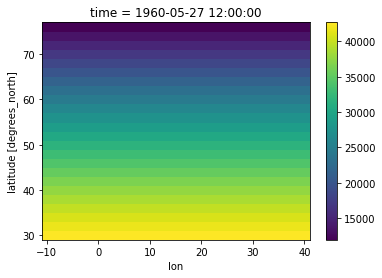

In [35]:
area_cell.plot()

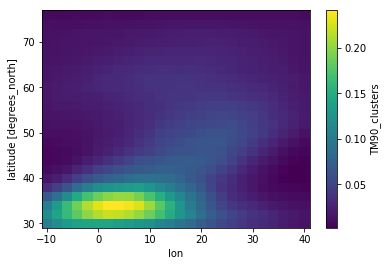

In [69]:
var_bool_blocked_clusters.mean(axis=0).plot()

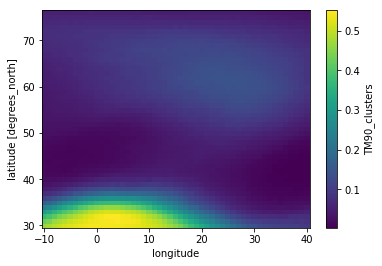

In [33]:
AGP=xr.open_dataset("/rds/general/user/cmt3718/home/data/reanal/AGP/AGP_clusters_data_day_EUR_era5_JJAextd.nc")['TM90_clusters']

AGP.mean(axis=0).plot()


In [45]:
TM90_2D_xr.to_netcdf('/rds/general/user/cmt3718/home/data/AGP/AGP_cmip6_piControl_UKESM1-0-LL_EUR2_JJAextd_1960-2060.nc')  

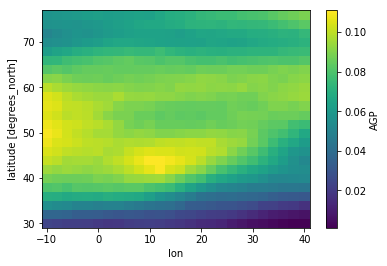

In [39]:
TM90_2D_xr.mean(axis=0).plot()

In [47]:
TM90_2D_xrtot=xr.open_dataset("/rds/general/user/cmt3718/home/data/UKESM1-0-LL_piControl/AGP/AGP_clusters_UKESM1-0-LL_r1i1p1f2_EUR_piControl_JJAextd_1960-2060.nc")['TM90_clusters']

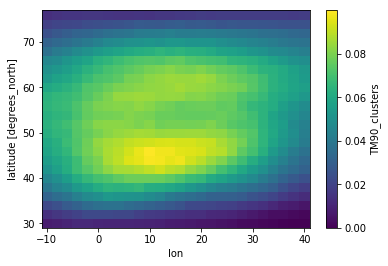

In [50]:
TM90_2D_xrtot.mean(axis=0).plot()